<a href="https://colab.research.google.com/github/konikhzed/Fayton/blob/main/3D2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🔥 شروع تست‌ها در محیط Google Colab (نسخه پایدار)...


============================== تست Breast Cancer ==============================

ارزیابی روی دیتاست: Breast Cancer
نمونه‌ها: 569, ویژگی‌ها: 30

🔥 نمایش الگوهای ترکیبی 2D/3D...


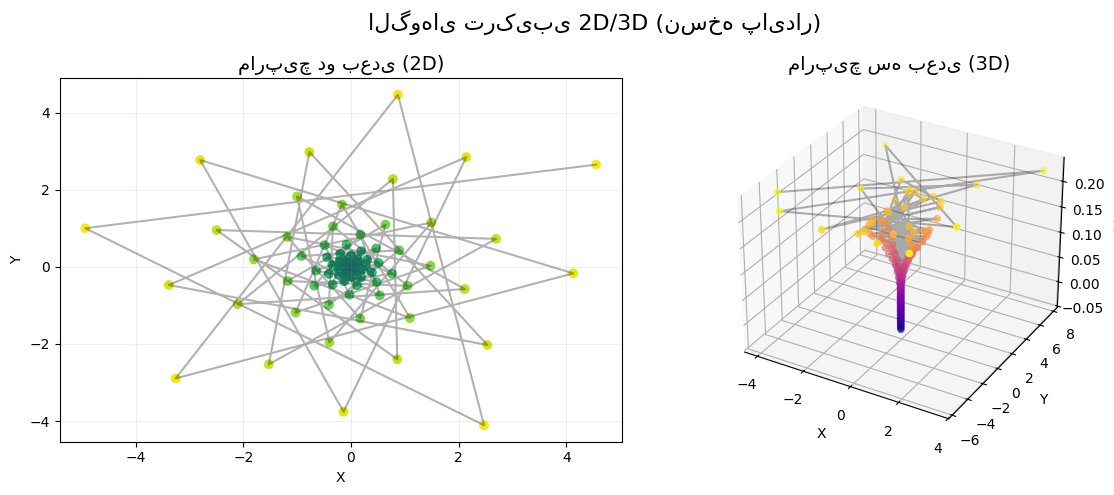


⏳ در حال آموزش مدل ترکیبی...

نتایج نهایی:
- مدل پایه (جنگل تصادفی): دقت = 0.9561
- مدل ترکیبی 2D/3D: دقت = 0.9474
➕ افزایش عملکرد: -0.88%

============================== تست Wine ==============================

ارزیابی روی دیتاست: Wine
نمونه‌ها: 178, ویژگی‌ها: 13

🔥 نمایش الگوهای ترکیبی 2D/3D...


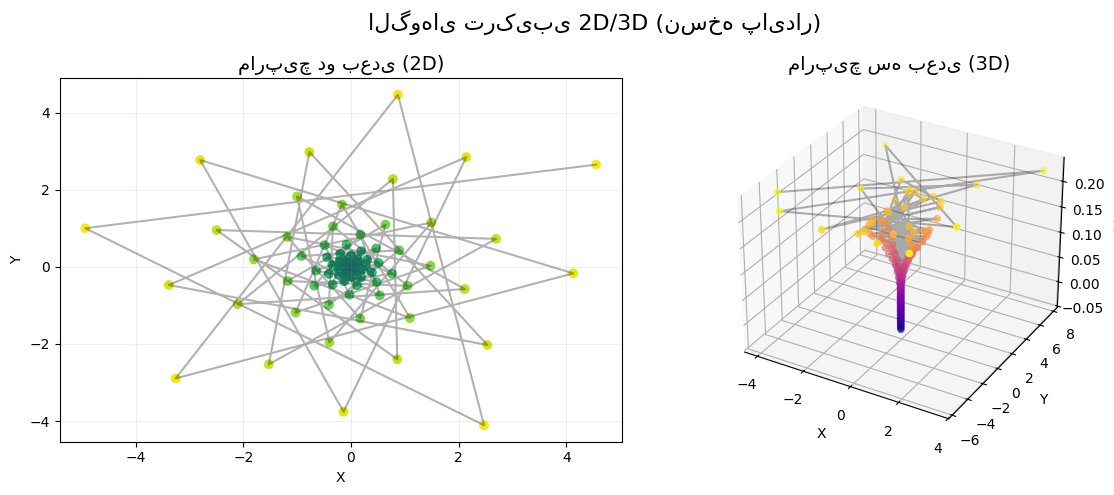


⏳ در حال آموزش مدل ترکیبی...

نتایج نهایی:
- مدل پایه (جنگل تصادفی): دقت = 1.0000
- مدل ترکیبی 2D/3D: دقت = 1.0000
➕ افزایش عملکرد: 0.00%

============================== تست Iris ==============================

ارزیابی روی دیتاست: Iris
نمونه‌ها: 150, ویژگی‌ها: 4

🔥 نمایش الگوهای ترکیبی 2D/3D...


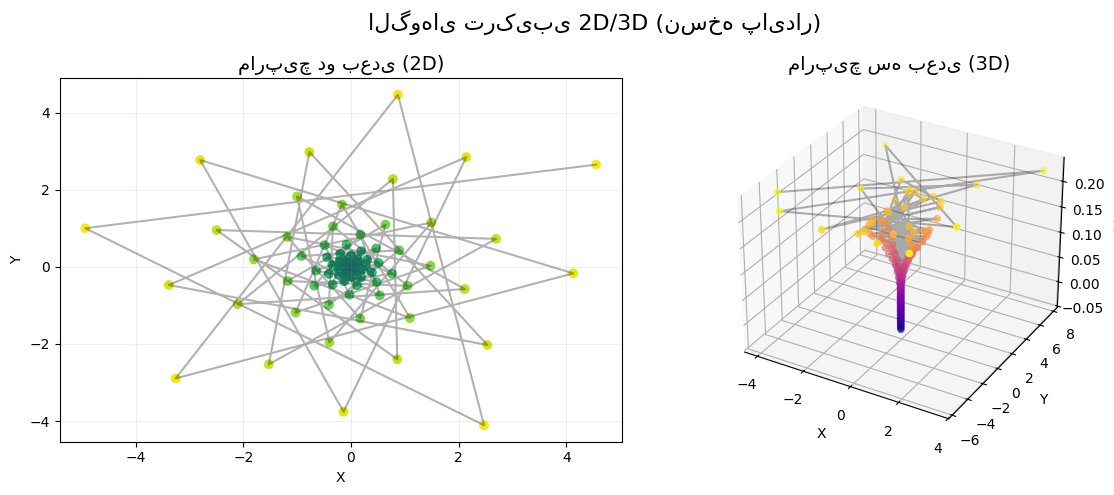


⏳ در حال آموزش مدل ترکیبی...

نتایج نهایی:
- مدل پایه (جنگل تصادفی): دقت = 0.9000
- مدل ترکیبی 2D/3D: دقت = 0.9000
➕ افزایش عملکرد: 0.00%


نتایج نهایی همه تست‌ها:
          دیتاست  مدل پایه (دقت)  مدل ترکیبی (دقت)  تعداد نمونه‌ها  \
0  Breast Cancer         0.95614          0.947368             569   
1           Wine         1.00000          1.000000             178   
2           Iris         0.90000          0.900000             150   

   تعداد ویژگی‌ها افزایش دقت  
0              30     -0.88%  
1              13      0.00%  
2               4      0.00%  

نتایج در فایل hybrid_model_results_stable.csv ذخیره شد


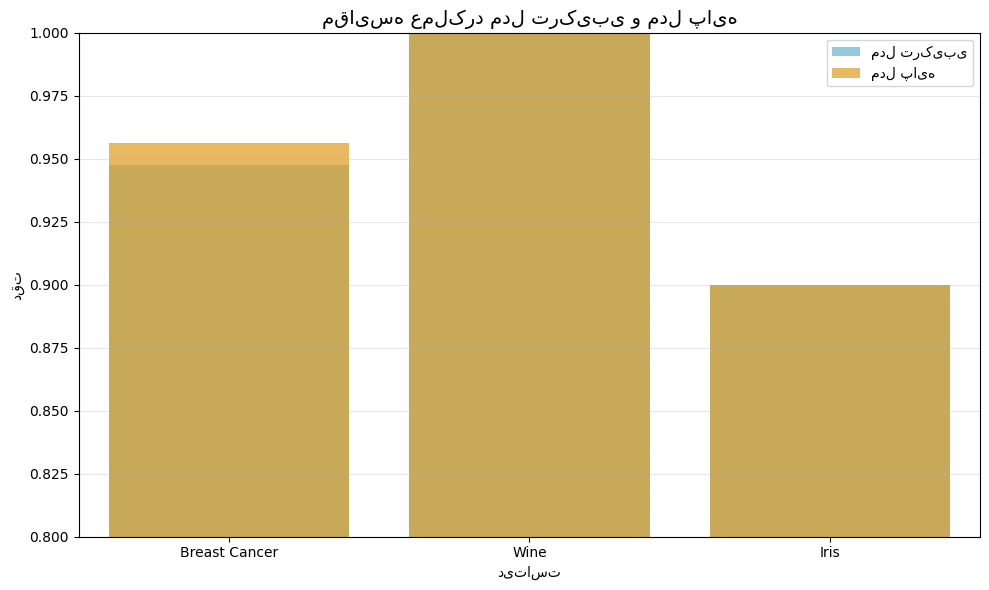

In [1]:

!pip install scikit-learn numpy matplotlib seaborn pandas --quiet
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.metrics import accuracy_score, f1_score
from sklearn.datasets import load_iris, load_breast_cancer, load_wine
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
import warnings

# غیرفعال کردن هشدارها
warnings.filterwarnings('ignore')

class HybridUncertaintyModel(BaseEstimator, ClassifierMixin):
    """
    مدل ترکیبی عدم قطعیت طلایی (نسخه پایدار)
    """

    def __init__(self, uncertainty_level=0.1, adaptive_noise=True,
                 random_state=None, phi_ratio=0.618):
        # پارامترهای نسبت طلایی
        self.φ = (1 + np.sqrt(5)) / 2  # ≈1.618
        self.φ_inv = phi_ratio         # ≈0.618
        self.φ_angle = 2 * np.pi * self.φ_inv  # زاویه طلایی

        # پارامترهای مدل
        self.uncertainty_level = uncertainty_level
        self.adaptive_noise = adaptive_noise
        self.random_state = random_state
        np.random.seed(random_state)

        # اطلاعات توسعه‌دهنده
        self.creator = "konikhzed"
        self.model_signature = f"HybridGU-{self.creator}-v4.1"

    def generate_hybrid_spiral(self, n_points):
        """تولید مارپیچ‌های پایدار 2D و 3D"""
        # مارپیچ دو بعدی (2D) با محدودیت رشد
        spiral_2d = np.zeros((n_points, 2))
        angle = 0
        distance = 0.1

        for i in range(n_points):
            noise = np.random.normal(0, self.uncertainty_level * 0.3)
            spiral_2d[i, 0] = distance * np.cos(angle + noise)
            spiral_2d[i, 1] = distance * np.sin(angle + noise)
            angle += self.φ_angle

            # محدودیت رشد فاصله
            distance *= min(self.φ, 1.05)  # حداکثر رشد 5% در هر مرحله

        # مارپیچ سه بعدی (3D) با محدودیت رشد
        spiral_3d = np.zeros((n_points, 3))
        z = 0
        angle_3d = 0
        distance_3d = 0.1

        for i in range(n_points):
            noise = np.random.normal(0, self.uncertainty_level * 0.2)
            spiral_3d[i, 0] = distance_3d * np.cos(angle_3d + noise)
            spiral_3d[i, 1] = distance_3d * np.sin(angle_3d * 0.7 + noise)
            spiral_3d[i, 2] = z

            angle_3d += self.φ_angle * 0.8
            z += 0.05 * self.φ_inv

            # محدودیت رشد فاصله
            distance_3d *= min(self.φ, 1.05)  # حداکثر رشد 5% در هر مرحله

        # نرمال‌سازی مارپیچ‌ها
        spiral_2d = (spiral_2d - np.mean(spiral_2d)) / (np.std(spiral_2d) + 1e-8)
        spiral_3d = (spiral_3d - np.mean(spiral_3d)) / (np.std(spiral_3d) + 1e-8)

        return spiral_2d, spiral_3d

    def add_hybrid_uncertainty(self, X):
        """افزودن عدم قطعیت ترکیبی به داده‌ها (نسخه پایدار)"""
        n_samples = X.shape[0]
        spiral_2d, spiral_3d = self.generate_hybrid_spiral(n_samples)

        # ترکیب الگوهای 2D و 3D با کنترل مقیاس
        hybrid_pattern = np.zeros(X.shape)

        for i in range(X.shape[1]):
            if i % 3 == 0:  # ویژگی‌های مضرب 3: الگوی 3D
                dim = i % 3
                scale_factor = min(1.0, self.φ_inv ** (i//3))
                hybrid_pattern[:, i] = spiral_3d[:, dim] * scale_factor
            else:  # سایر ویژگی‌ها: الگوی 2D
                dim = (i % 2)
                scale_factor = min(1.0, self.φ_inv ** (i//2))
                hybrid_pattern[:, i] = spiral_2d[:, dim] * scale_factor

        # تطبیق مقیاس با داده‌ها
        if self.adaptive_noise:
            feature_scales = np.std(X, axis=0)
            hybrid_pattern = hybrid_pattern * feature_scales

        # نویز پایه کنترل‌شده
        base_noise = np.random.normal(
            0,
            self.uncertainty_level * self.φ_inv,
            X.shape
        )

        # ترکیب نهایی با کنترل دامنه
        X_modified = X + 0.1 * base_noise + 0.5 * hybrid_pattern * self.uncertainty_level

        # جلوگیری از مقادیر بی‌نهایت
        X_modified = np.clip(X_modified, -1e10, 1e10)

        return X_modified

    def fit(self, X, y):
        """آموزش مدل با داده‌های ترکیبی"""
        X, y = check_X_y(X, y)
        X_uncertain = self.add_hybrid_uncertainty(X)

        self.classifier_ = RandomForestClassifier(
            n_estimators=150,
            random_state=self.random_state
        )
        self.classifier_.fit(X_uncertain, y)

        self.n_features_in_ = X.shape[1]
        self.classes_ = np.unique(y)
        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        return self.classifier_.predict(X)

    def visualize_hybrid_spiral(self, n_points=200):
        """نمایش مارپیچ ترکیبی پایدار"""
        spiral_2d, spiral_3d = self.generate_hybrid_spiral(n_points)

        # نمودار 2D
        plt.figure(figsize=(12, 5))
        plt.subplot(121)
        plt.scatter(spiral_2d[:, 0], spiral_2d[:, 1], c=np.arange(n_points), cmap='viridis')
        plt.plot(spiral_2d[:, 0], spiral_2d[:, 1], 'k-', alpha=0.3)
        plt.title('مارپیچ دو بعدی (2D)', fontsize=14)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(True, alpha=0.2)

        # نمودار 3D
        ax = plt.subplot(122, projection='3d')
        ax.scatter(spiral_3d[:, 0], spiral_3d[:, 1], spiral_3d[:, 2],
                  c=np.arange(n_points), cmap='plasma', s=20)
        ax.plot(spiral_3d[:, 0], spiral_3d[:, 1], spiral_3d[:, 2], 'k-', alpha=0.3)
        ax.set_title('مارپیچ سه بعدی (3D)', fontsize=14)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        plt.suptitle('الگوهای ترکیبی 2D/3D (نسخه پایدار)', fontsize=16)
        plt.tight_layout()
        plt.savefig('hybrid_spiral_stable.png', dpi=200)
        plt.show()

def run_full_test(dataset_name="Breast Cancer"):
    """اجرای تست کامل روی دیتاست‌های مختلف"""
    # بارگذاری دیتاست
    if dataset_name == "Breast Cancer":
        data = load_breast_cancer()
    elif dataset_name == "Wine":
        data = load_wine()
    elif dataset_name == "Iris":
        data = load_iris()
    else:
        raise ValueError("دیتاست پشتیبانی نمی‌شود")

    X, y = data.data, data.target
    print(f"\n{'='*50}")
    print(f"ارزیابی روی دیتاست: {dataset_name}")
    print(f"نمونه‌ها: {X.shape[0]}, ویژگی‌ها: {X.shape[1]}")
    print(f"{'='*50}")

    # تقسیم داده‌ها
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # مدل پایه (بدون عدم قطعیت)
    base_model = RandomForestClassifier(n_estimators=150, random_state=42)
    base_model.fit(X_train, y_train)
    base_acc = accuracy_score(y_test, base_model.predict(X_test))

    # مدل ترکیبی ما
    hybrid_model = HybridUncertaintyModel(
        uncertainty_level=0.15,
        phi_ratio=0.618,
        random_state=42
    )

    # نمایش مارپیچ ترکیبی
    print("\n🔥 نمایش الگوهای ترکیبی 2D/3D...")
    hybrid_model.visualize_hybrid_spiral(n_points=150)

    # آموزش مدل
    print("\n⏳ در حال آموزش مدل ترکیبی...")
    hybrid_model.fit(X_train, y_train)

    # ارزیابی
    hybrid_acc = accuracy_score(y_test, hybrid_model.predict(X_test))

    # نتایج
    results = {
        'دیتاست': dataset_name,
        'مدل پایه (دقت)': base_acc,
        'مدل ترکیبی (دقت)': hybrid_acc,
        'تعداد نمونه‌ها': X.shape[0],
        'تعداد ویژگی‌ها': X.shape[1],
        'افزایش دقت': f"{100*(hybrid_acc - base_acc):.2f}%"
    }

    print("\nنتایج نهایی:")
    print(f"- مدل پایه (جنگل تصادفی): دقت = {base_acc:.4f}")
    print(f"- مدل ترکیبی 2D/3D: دقت = {hybrid_acc:.4f}")
    print(f"➕ افزایش عملکرد: {100*(hybrid_acc - base_acc):.2f}%")

    return results

# اجرای تست روی دیتاست‌های مختلف
if __name__ == "__main__":
    print("🔥 شروع تست‌ها در محیط Google Colab (نسخه پایدار)...\n")

    # اجرا روی ۳ دیتاست معتبر
    datasets = ["Breast Cancer", "Wine", "Iris"]
    all_results = []

    for dataset in datasets:
        print(f"\n{'='*30} تست {dataset} {'='*30}")
        results = run_full_test(dataset)
        all_results.append(results)

    # نمایش نتایج نهایی
    results_df = pd.DataFrame(all_results)
    print("\n\n" + "="*50)
    print("نتایج نهایی همه تست‌ها:")
    print("="*50)
    print(results_df)

    # ذخیره نتایج
    results_df.to_csv('hybrid_model_results_stable.csv', index=False)
    print("\nنتایج در فایل hybrid_model_results_stable.csv ذخیره شد")

    # نمایش نمودار مقایسه
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=results_df,
        x='دیتاست',
        y='مدل ترکیبی (دقت)',
        color='skyblue',
        label='مدل ترکیبی'
    )
    sns.barplot(
        data=results_df,
        x='دیتاست',
        y='مدل پایه (دقت)',
        color='orange',
        alpha=0.7,
        label='مدل پایه'
    )
    plt.title('مقایسه عملکرد مدل ترکیبی و مدل پایه', fontsize=14)
    plt.ylabel('دقت')
    plt.ylim(0.8, 1.0)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('comparison_results.png', dpi=300)
    plt.show()